# Всероссийская олимпиада по искусственному интеллекту 2025

## Введение в задачу Keyword Spotting

Добро пожаловать в задачу **Не слышу тебя**, которая является примером **Keyword Spotting (KWS)** — распознавания ключевых фраз в аудиозаписях. В этом ноутбуке показано, как подготовить данные к работе с ними.

### Описание задачи

Во время телефонных или видеозвонков качество связи может резко ухудшаться: звук пропадает, речь прерывается, собеседники перестают друг друга слышать. Один из способов автоматического обнаружения таких проблем — анализ аудиопотока на предмет ключевых фраз, по которым можно определить, что связь прервалась.

В этой задаче рассматриваются две такие фразы: «не слышу» и «не слышно». Их появление в разговоре сигнализирует о том, что пользователь испытывает проблемы с восприятием речи собеседника, что может быть связано с плохим интернет-соединением, неисправностью аудиотракта или помехами в канале связи.

Создание и внедрение такой модели позволит:
- оперативно определять ухудшение качества связи в реальном времени;
- автоматизировать сбор статистики о проблемах в звонках;
- инициировать технические меры для улучшения соединения (например, переключение кодека или перезапуск соединения);
- использовать полученную информацию для аналитики и повышения качества сервиса.

### Цель задачи

Необходимо построить модель, которая для каждой аудиозаписи определит, **содержит ли она хотя бы одну из целевых фраз «не слышу» или «не слышно»**.

- Метка **1** — в записи есть хотя бы одна из этих фраз.
- Метка **0** — таких фраз нет.

Таким образом, задача представляет собой **бинарную классификацию аудиозаписей**: модель должна различать записи с целевыми словами и без них.

### Структура датасета

Наш датасет содержит:

**Тренировочные данные:**
- Папка `train_opus/audio/` - аудиофайлы в формате OPUS
- Файл `train_opus/word_bounds.json` - разметка с временными границами ключевых слов

**Тестовые данные:**
- Папка `test_opus/audio/` - аудиофайлы без разметки

**Формат разметки:**
```json
{
  "file_id": [start_time, end_time],
  ...
}
```

**Типы примеров:**
- **Положительные** (pos) - содержат ключевое слово
- **Отрицательные** (neg) - не содержат ключевое слово

### **Импорты и настройка окружения**

In [1]:
import os
import re
import requests
import subprocess
from pathlib import Path
from tqdm import tqdm


def get_direct_file_link(mailru_file_url: str) -> str:
    """
    Преобразует публичную ссылку вида:
        https://cloud.mail.ru/public/<key>/<subkey>/<filename>
    в прямую ссылку на CDN, по которой можно скачать файл через wget или requests.

    Возвращает прямую ссылку для скачивания.
    """
    resp = requests.get(mailru_file_url)
    if resp.status_code != 200:
        raise RuntimeError(f"Ошибка {resp.status_code} при запросе {mailru_file_url}")

    match = re.search(r'dispatcher.*?weblink_get.*?url":"(.*?)"', resp.text)
    if not match:
        raise RuntimeError("Не удалось найти CDN ссылку в HTML Mail.ru")

    base_url = match.group(1)
    parts = mailru_file_url.strip("/").split("/")[-3:]
    return f"{base_url}/{parts[0]}/{parts[1]}/{parts[2]}"


def download_from_mailru(file_url: str, local_name: str, force: bool = False, show_progress: bool = True):
    """
    Скачивает файл с Mail.ru по публичной ссылке.

    Args:
        file_url: ссылка на файл в облаке Mail.ru.
        local_name: имя файла для сохранения.
        force: если True — перекачивает даже если файл уже есть.
        show_progress: показывать ли прогресс-бар.
    """
    local_path = Path(local_name)
    if local_path.exists() and not force:
        print(f"Файл {local_name} уже существует, пропускаем скачивание.")
        return

    direct = get_direct_file_link(file_url)
    print(f"Скачиваем {file_url} → {local_name}")

    with requests.get(direct, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get("content-length", 0))
        block_size = 8192
        with open(local_name, "wb") as f, tqdm(
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
            desc=f"Downloading {local_name}",
            disable=not show_progress,
        ) as bar:
            for chunk in r.iter_content(block_size):
                f.write(chunk)
                bar.update(len(chunk))

    print(f"Файл {local_name} успешно скачан ({os.path.getsize(local_name)/1e6:.1f} MB).")

In [2]:
# Ссылки на данные по задаче
train_link = "https://cloud.mail.ru/public/Gsyr/8VxmbhAaZ/train_data.tar"
test_link  = "https://cloud.mail.ru/public/Gsyr/8VxmbhAaZ/test_data.tar"

In [3]:
# Если скорость загрузки низкая — это может быть связано с CDN.
# Попробуйте перезапустить ячейку: при новом соединении может попасться другой узел CDN,
# и загрузка обычно проходит быстрее (2-3 минуты при нормальном узле).
download_from_mailru(train_link, "train_data.tar")
download_from_mailru(test_link, "test_data.tar")

Скачиваем https://cloud.mail.ru/public/Gsyr/8VxmbhAaZ/train_data.tar → train_data.tar


Файл train_data.tar успешно скачан (2472.0 MB).
Скачиваем https://cloud.mail.ru/public/Gsyr/8VxmbhAaZ/test_data.tar → test_data.tar


Файл test_data.tar успешно скачан (741.0 MB).


In [4]:
# Распаковка
subprocess.run(["tar", "xf", "train_data.tar"], check=True)
subprocess.run(["tar", "xf", "test_data.tar"], check=True)
print("Готово.")

Готово.


In [5]:
from pathlib import Path
from glob import glob
import json
import random

def _pick_existing(*candidates):
    for p in candidates:
        p = Path(p)
        if (p / "audio").exists():
            return p
    return None

train_dir = _pick_existing("train_data", "train_opus")
test_dir  = _pick_existing("test_data",  "test_opus")

if train_dir is None or test_dir is None:
    raise RuntimeError(
        "Не найдены папки с данными. Ожидались train_data/ или train_opus/ (и аналогично для test_*/)."
    )

print(f"train_dir: {train_dir.resolve()}")
print(f"test_dir : {test_dir.resolve()}")

# Списки файлов
train_files = glob(str(train_dir / "audio" / "*.opus"))
test_files  = glob(str(test_dir  / "audio" / "*.opus"))

print(f"Количество тренировочных файлов: {len(train_files)}")
print(f"Количество тестовых файлов: {len(test_files)}")

# Загрузка разметки
wb_path = train_dir / "word_bounds.json"
if not wb_path.exists():
    raise FileNotFoundError(f"Не найден файл разметки: {wb_path}")

with open(wb_path, "r", encoding="utf-8") as f:
    word_bounds = json.load(f)

print(f"Количество размеченных файлов (по ключам в word_bounds.json): {len(word_bounds)}")

# Базовые счётчики
train_ids = {Path(p).stem for p in train_files}
test_ids  = {Path(p).stem for p in test_files}
pos_ids   = set(word_bounds.keys())

# Положительные — это пересечение ключей разметки с фактически существующими файлами
pos_in_train = pos_ids & train_ids
pos_count    = len(pos_in_train)
neg_count    = len(train_files) - pos_count

print("\nРаспределение классов в train (по наличию id в word_bounds.json):")
print(f"Положительные примеры: {pos_count} ({pos_count / max(len(train_files),1) * 100:.1f}%)")
print(f"Отрицательные примеры: {neg_count} ({neg_count / max(len(train_files),1) * 100:.1f}%)")

# Полезные sanity-check'и
missing_annot_ids = pos_ids - train_ids
if missing_annot_ids:
    print(f"\nПредупреждение: в разметке есть {len(missing_annot_ids)} id, "
          f"для которых не найден файл в {train_dir/'audio'} (первые 5): "
          f"{sorted(list(missing_annot_ids))[:5]}")

test_leak_ids = pos_ids & test_ids
if test_leak_ids:
    print(f"\nПредупреждение: обнаружены {len(test_leak_ids)} id из теста, присутствующие в word_bounds.json "
          f"(первые 5): {sorted(list(test_leak_ids))[:5]}")

# Дубликаты по stem (на всякий случай)
def _dup_stems(paths):
    stems = [Path(p).stem for p in paths]
    seen, dup = set(), set()
    for s in stems:
        if s in seen:
            dup.add(s)
        else:
            seen.add(s)
    return dup

dup_train = _dup_stems(train_files)
dup_test  = _dup_stems(test_files)
if dup_train:
    print(f"\nПредупреждение: дубликаты id в train: {len(dup_train)} (первые 5): {sorted(list(dup_train))[:5]}")
if dup_test:
    print(f"\nПредупреждение: дубликаты id в test: {len(dup_test)} (первые 5): {sorted(list(dup_test))[:5]}")

# Небольшое превью
def _preview(ids_set, n=5):
    ids_list = sorted(list(ids_set))
    random.seed(0)
    return sorted(random.sample(ids_list, min(n, len(ids_list))))

print("\nПримеры id из train:", _preview(train_ids, 5))
print("Примеры id из test :", _preview(test_ids, 5))
print("Примеры POS id     :", _preview(pos_in_train, 5))


train_dir: /content/train_opus
test_dir : /content/test_opus
Количество тренировочных файлов: 90000
Количество тестовых файлов: 27000
Количество размеченных файлов (по ключам в word_bounds.json): 45000

Распределение классов в train (по наличию id в word_bounds.json):
Положительные примеры: 45000 (50.0%)
Отрицательные примеры: 45000 (50.0%)

Примеры id из train: ['0578706700521351846393642918886346925726', '3747623082454920429904507450062128040033', '5600513868334424866262280573577017975423', '6115258489815918371243570488516101842182', '7447369466826958236737655344544781920680']
Примеры id из test : ['0499438862317083278182675188266545621622', '3161809059075456484089887853187931721551', '4695837353874467852979108224819486928786', '5125349328490651777970264902178208387036', '9188837987070080381694995888667050393849']
Примеры POS id     : ['0588658564848284222758254070217825981013', '3743858473378128480264214418181389794712', '5598385971789991196651732353383092448330', '61125677618391950

Пример положительного файла:


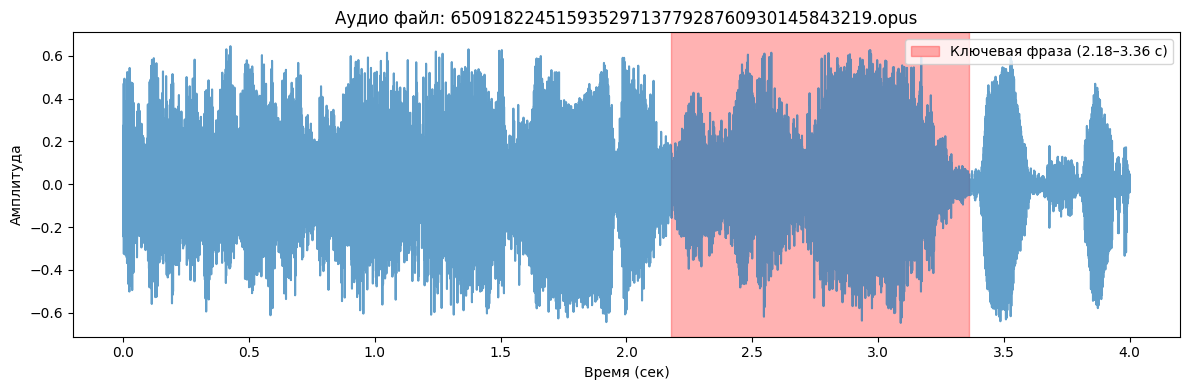

Прослушать 6509182245159352971377928760930145843219.opus (длина 4.00 с, sr=16000)



Пример отрицательного файла:


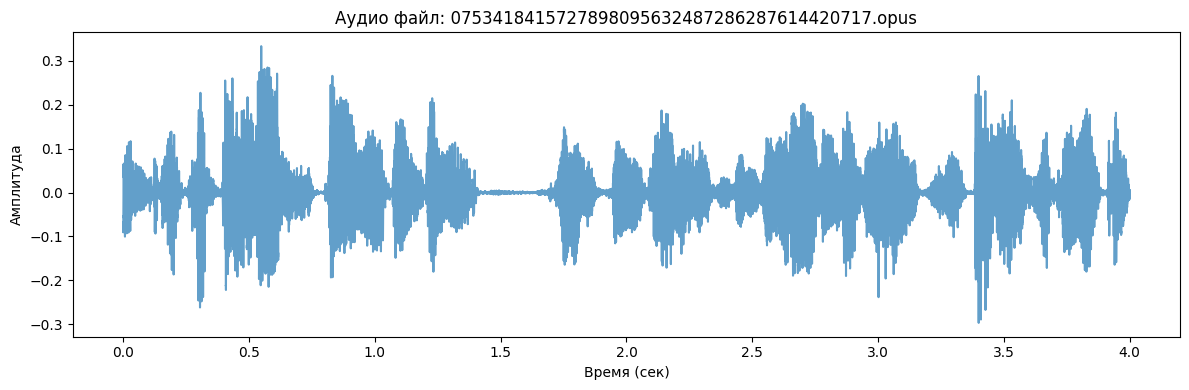

Прослушать 0753418415727898095632487286287614420717.opus (длина 4.00 с, sr=16000)


In [6]:
from IPython.display import Audio, display
import librosa
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import soundfile as sf


def safe_load_audio(path, sr_target=16000):
    """
    Безопасно загружаем аудио. Пытаемся использовать librosa,
    при неудаче fallback на soundfile.
    """
    try:
        audio, sr = librosa.load(path, sr=sr_target)
    except Exception:
        data, sr = sf.read(path, dtype="float32", always_2d=False)
        if sr != sr_target:
            audio = librosa.resample(data, orig_sr=sr, target_sr=sr_target)
            sr = sr_target
        else:
            audio = data
    return audio, sr


def plot_audio_sample(file_path, word_bounds=None, sr_target=16000, play=True):
    """
    Визуализируем и при необходимости воспроизводим аудиофайл.

    Args:
        file_path: путь к аудио (str | Path)
        word_bounds: словарь {id: [start, end]} с разметкой
        sr_target: частота дискретизации для загрузки
        play: если True — воспроизводит аудио
    """
    file_path = Path(file_path)
    file_id = file_path.stem

    try:
        audio, sr = safe_load_audio(file_path, sr_target)
    except Exception as e:
        print(f"Не удалось загрузить {file_path.name}: {e}")
        return None, None

    duration = len(audio) / sr

    # Визуализация
    plt.figure(figsize=(12, 4))
    time = np.linspace(0, duration, len(audio))
    plt.plot(time, audio, alpha=0.7)
    plt.title(f"Аудио файл: {file_path.name}")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда")

    # Подсветка сегмента с ключевым словом
    if word_bounds and file_id in word_bounds:
        start, end = word_bounds[file_id]
        plt.axvspan(start, end, alpha=0.3, color="red",
                    label=f"Ключевая фраза ({start:.2f}–{end:.2f} с)")
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Прослушивание
    if play:
        print(f"Прослушать {file_path.name} (длина {duration:.2f} с, sr={sr})")
        display(Audio(audio, rate=sr))

    return audio, sr


# Примеры положительных и отрицательных файлов
print("Пример положительного файла:")
pos_files = [f for f in train_files if Path(f).stem in word_bounds]
if pos_files:
    plot_audio_sample(pos_files[0], word_bounds)

print("\nПример отрицательного файла:")
neg_files = [f for f in train_files if Path(f).stem not in word_bounds]
if neg_files:
    plot_audio_sample(neg_files[1])


Теперь реализуем `Dataloader` для работы с каждым из датасетов. В обучении и инференсе мы решаем **разные подзадачи**, поэтому формат данных и требования к батчингу отличаются.

### Обучение: короткие фиксированные сегменты с метками
На этапе обучения модели важно:
- видеть **много разнообразных коротких примеров** одной длины (например, 1 сек);
- явно знать метку класса: 1 — фраза «не слышу/не слышно» присутствует, 0 — отсутствует;
- у позитивных примеров гарантировать, что **фраза попадает внутрь окна**, а вокруг присутствует небольшой контекст.

Поэтому `KWSDataset`:
- загружает полный сигнал и **вырезает фиксированное окно** длины `seg_size_samples`;
- для позитивов берёт окно, в которое гарантированно попадает интервал `word_bounds` (см. `pick_positive_window`);
- для негативов выбирает равномерное окно по записи (см. `pick_negative_window`);
- доводит каждый пример до **одинаковой длины** (`ensure_length`) — так батч можно склеить простым `torch.stack`;
- возвращает `(segment, label, aux)`, где `segment` — тензор формы `[T]`, `label ∈ {0,1}`, `aux` — техническая информация (путь, длительность, интервал).

Это обеспечивает стабильный батчинг и контролируемый баланс классов, а также регуляризацию за счёт случайных сдвигов окна и контекстов.

### Инференс (тест): полная запись и переменная длина во времени
На тесте задача иная:
- для каждого файла нужно выдать **ровно одно предсказание**;
- нельзя обрезать запись произвольно — модель должна иметь возможность посмотреть на **всю запись**;
- длины файлов разные, значит длина признаков по времени тоже будет разной.

Поэтому `TestDataset`:
- загружает **весь сигнал** (без сегментации);
- преобразует его в **лог-mel спектрограмму** `[n_mels, T]` с переменной длиной `T`;
- возвращает `(mel, file_id, duration_sec)`, где `file_id` удобен для формирования `submission.csv`.

При сборке батча в тестовом лоадере используем `collate_mels_pad_time`: он **паддит по времени** до `T_max` внутри батча, чтобы получить тензор `[B, n_mels, T_max]`.

### Переиспользуемые функции и единые допущения
Чтобы код не дублировать и вести себя одинаково на train/test, мы вынесли общие шаги в вспомогательные функции:

- `load_audio_16k(path, sr_target=16000)` — **единый способ загрузки и ресемплинга** до 16 кГц.  
  Используется и в `KWSDataset`, и в `TestDataset`. Сначала пробует `torchaudio.load` (надежно для Opus при наличии ffmpeg), затем резервно `librosa.load`.

- `ensure_length(wav, target_len)` — доведение до фиксированной длины (обрезка/паддинг нулями).  
  Используется в `KWSDataset` для сегментов фиксированного размера.

- `pick_positive_window(...)` и `pick_negative_window(...)` — единая логика выбора окон для обучения.  
  Эти функции отвечают за корректность попадания фразы внутрь окна и за разнообразие контекста.

Также и на train, и на test применяем **одинаковую нормализацию по пику** (необязательную, но полезную): это делает амплитуды сопоставимыми, упрощает обучение и стабилизирует признаки.


In [7]:
import math
import random
from pathlib import Path
from typing import List, Tuple, Dict, Optional, Union

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Мы используем torchaudio как основной бэкенд (лучше читает opus),
# а librosa — как резервный вариант для подстраховки.
import torchaudio
import numpy as np
import librosa

def load_audio_16k(path: Union[str, Path], sr_target: int = 16000) -> torch.Tensor:
    """
    Загрузка аудио в 16 кГц, моно, float32 -> torch.float32.

    Порядок:
    1) torchaudio.load (часто лучший выбор для .opus при наличии ffmpeg)
    2) librosa.load как резервный путь

    Возвращает:
        wav: Tensor [T] в диапазоне примерно [-1, 1]
    """
    path = str(path)
    try:
        wav, sr = torchaudio.load(path)  # wav: [C, T], float32/float64/…
        # моно
        if wav.dim() == 2:
            if wav.size(0) > 1:
                wav = wav.mean(dim=0, keepdim=True)  # усредняем каналы
            wav = wav.squeeze(0)  # -> [T]

        # ресемплинг при необходимости
        if sr != sr_target:
            wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=sr_target)

        # гарантируем float32
        if wav.dtype != torch.float32:
            wav = wav.float()
        return wav
    except Exception:
        # librosa (например, если нет ffmpeg-бэкенда у torchaudio)
        y, sr = librosa.load(path, sr=sr_target, mono=True)
        wav = torch.from_numpy(y.astype(np.float32))
        return wav


def ensure_length(wav: torch.Tensor, target_len: int) -> torch.Tensor:
    """
    Приводим сигнал к заданной длине target_len с помощью паддинга нулями или обрезания.
    Важно для батчинга: у всех сегментов одинаковая длина.
    """
    T = wav.numel()
    if T == target_len:
        return wav
    if T > target_len:
        return wav[:target_len]
    # паддинг справа
    pad = target_len - T
    return torch.nn.functional.pad(wav, (0, pad))


def pick_positive_window(
    T: int,
    sr: int,
    seg_size: int,
    bounds: Tuple[float, float],
    context_frac: float = 0.5,
) -> Tuple[int, int]:
    """
    Возвращает [left, right) индексы окна длины seg_size так, чтобы целевая фраза попала внутрь,
    и при этом оставалось немного контекста до/после (задается долей context_frac).

    Идея:
    - Есть интервал фразы [t0, t1] в секундах. Его длина Lp = (t1 - t0) * sr.
    - Мы хотим поместить этот интервал в окно длины seg_size, желательно не "впритык".
    - Сначала вычисляем допустимый диапазон для левого края окна так, чтобы фраза полностью влезла.
    - Затем случайно сдвигаем окно в этом диапазоне (даёт разнообразие).
    """
    t0, t1 = bounds
    # Границы фразы в сэмплах
    p0 = int(round(t0 * sr))
    p1 = int(round(t1 * sr))
    p0 = max(0, min(T, p0))
    p1 = max(0, min(T, p1))
    pos_len = max(1, p1 - p0)

    # Если фраза длиннее окна, берём центральный фрагмент фразы
    if pos_len >= seg_size:
        center = (p0 + p1) // 2
        left = max(0, center - seg_size // 2)
        right = min(T, left + seg_size)
        left = right - seg_size
        return left, right

    # Иначе фраза короче окна -> разместим её внутри окна с контекстом
    free = seg_size - pos_len

    # Доля контекста до/после. Например, context_frac=0.5 -> симметричный контекст
    # но мы слегка рандомизируем долю слева/справа
    alpha = np.clip(np.random.normal(loc=context_frac, scale=0.15), 0.0, 1.0)
    left_ctx = int(alpha * free)
    right_ctx = free - left_ctx

    left = p0 - left_ctx
    right = p1 + right_ctx

    # Если окно "вылезает" за аудио — подвинем
    if left < 0:
        shift = -left
        left = 0
        right = min(T, right + shift)
    if right > T:
        shift = right - T
        right = T
        left = max(0, left - shift)

    # На всякий случай — фиксированная длина
    if right - left != seg_size:
        right = min(T, left + seg_size)
        left = right - seg_size
        left = max(0, left)
    return left, right


def pick_negative_window(T: int, seg_size: int) -> Tuple[int, int]:
    """
    Простой случай для отрицательного окна: равномерно выбираем позицию,
    если сигнал короче seg_size — окно начнётся с 0, а остаток добьётся нулями.
    """
    if T <= seg_size:
        return 0, min(T, seg_size)
    left = random.randint(0, T - seg_size)
    right = left + seg_size
    return left, right


class KWSDataset(Dataset):
    """
    Базовый датасет для KWS.

    Ожидаемые входы:
        pos_items: список положительных примеров [(path, (start_sec, end_sec)), ...]
        neg_items: список отрицательных примеров [(path, None), ...] или [(path, ()), ...]
    где:
        - path: путь к .opus
        - (start_sec, end_sec): границы фразы из word_bounds.json для данного файла
          (если в файле несколько фрагментов, можно передавать список — см. ниже расширение)

    Параметры:
        seg_size_samples: длина сегмента в сэмплах (для 1 сек при 16кГц: 16000)
        sr: частота дискретизации для загрузки и сегментации (обычно 16000)
        mix_posneg: если True — формируем единый пул и даем DataLoader'у управлять shuffle;
                    если False — можно реализовать собственную балансировку.
        seed: сид для воспроизводимости.
    """

    def __init__(
        self,
        pos_items: List[Tuple[Union[str, Path], Tuple[float, float]]],
        neg_items: List[Tuple[Union[str, Path], Optional[Tuple[float, float]]]],
        seg_size_samples: int,
        sr: int = 16000,
        mix_posneg: bool = True,
        seed: Optional[int] = None,
        allow_negative_inside_positive: bool = False,
    ):
        super().__init__()
        self.sr = sr
        self.seg_size = int(seg_size_samples)
        self.rng = random.Random(seed)

        # Нормализуем вход: приводим пути к Path, фильтруем битые записи
        def _normalize(items, is_pos: bool):
            out = []
            for it in items:
                if isinstance(it, (list, tuple)) and len(it) == 2:
                    p, b = it
                else:
                    # допускаем формат просто (path,) для отрицательных
                    p, b = it, None
                p = Path(p)
                if not p.exists():
                    # лучше явно сигнализировать, но для демонстрационного ноутбука мы молча пропустим
                    continue
                if is_pos and (b is None or len(b) != 2):
                    # у положительного примера обязательно должны быть границы
                    continue
                out.append((p, b))
            return out

        self.pos_items = _normalize(pos_items, is_pos=True)
        self.neg_items = _normalize(neg_items, is_pos=False)

        if mix_posneg:
            # формируем единый пул (path, bounds, label)
            self.samples = [(p, b, 1) for p, b in self.pos_items] + [(p, None, 0) for p, _ in self.neg_items]
        else:
            # можно хранить раздельно и реализовать свою стратегию балансировки в __getitem__
            self.samples = [(p, b, 1) for p, b in self.pos_items] + [(p, None, 0) for p, _ in self.neg_items]

        # Флаг: разрешать ли извлекать отрицательные окна из «пустых зон» положительных файлов
        # (полезно при дефиците отрицательных примеров)
        self.allow_negative_inside_positive = allow_negative_inside_positive

    def __len__(self):
        return len(self.samples)

    def _get_segment(self, wav: torch.Tensor, label: int, bounds: Optional[Tuple[float, float]]) -> torch.Tensor:
        """
        Возвращает сегмент фиксированной длины для данного wav и метки.
        Для label==1 — гарантируем попадание фразы в окно.
        Для label==0 — равномерный выбор окна.

        Если wav слишком короткий — дополняем нулями.
        """
        T = wav.numel()

        # Если аудио пустое (редкий случай), вернем просто нули
        if T == 0:
            return torch.zeros(self.seg_size, dtype=torch.float32)

        if label == 1 and bounds is not None:
            left, right = pick_positive_window(T=T, sr=self.sr, seg_size=self.seg_size, bounds=bounds)
        else:
            left, right = pick_negative_window(T=T, seg_size=self.seg_size)

        seg = wav[left:right]
        seg = ensure_length(seg, self.seg_size)
        return seg

    def __getitem__(self, index: int):
        """
        Возвращает:
            segment: Tensor [seg_size] float32
            label:   int (0/1)
            aux:     словарь с технической информацией (путь, длительность и т.п.) — полезно для отладки
        """
        index = index % len(self.samples)
        path, bounds, label = self.samples[index]

        # Загрузка и нормализация аудио
        wav = load_audio_16k(path, sr_target=self.sr)

        # Нормализация амплитуды по RMS/peak может помочь (опционально).
        # Для простоты — легкий нормировщик по пику с защитой от деления на 0.
        peak = wav.abs().max().item()
        if peak > 0:
            wav = wav / peak

        # Сегмент
        segment = self._get_segment(wav, label, bounds)

        aux = {
            "path": str(path),
            "label": label,
            "duration_sec": len(wav) / float(self.sr),
            "bounds": bounds,
        }
        return segment, label, aux


# Сформируем pos/neg списки для датасета.
def build_pos_neg_lists(train_files: List[str], word_bounds: Dict[str, List[float]]) \
        -> Tuple[List[Tuple[str, Tuple[float, float]]], List[Tuple[str, None]]]:
    pos_items, neg_items = [], []
    for f in train_files:
        fid = Path(f).stem
        if fid in word_bounds:
            start, end = word_bounds[fid]
            pos_items.append((f, (float(start), float(end))))
        else:
            neg_items.append((f, None))
    return pos_items, neg_items

### Как выбрать длину сегмента

В коде параметр `seg_size_samples` определяет длину аудиофрагмента, который подаётся модели при обучении.
Сейчас он равен `16000`, что соответствует **1 секунде** при частоте дискретизации 16 кГц.

Однако на практике длину сегмента стоит **подбирать под задачу**:

- Слишком **короткий сегмент** приводит к тому, что модель часто видит неполную фразу  
  и делает много ложных срабатываний (false alarms, FA).
- Слишком **длинный сегмент** усложняет обучение: модель должна «помнить» длинный контекст,  
  а полезный сигнал занимает малую часть окна.

Хороший способ подобрать его — вычислить, выкоский перцентиль длины всех позитивных фраз  
из файла `word_bounds.json` и взять это значение как длину окна, с этим можно экспериментировать.


In [8]:
pos_items, neg_items = build_pos_neg_lists(train_files, word_bounds)

seg_size_samples = 16000  # 1 сек при 16 кГц
ds = KWSDataset(
    pos_items=pos_items,
    neg_items=neg_items,
    seg_size_samples=seg_size_samples,
    sr=16000,
    mix_posneg=True,
    seed=42,
)

def collate_fn(batch):
    segments, labels, aux = zip(*batch)
    segments = torch.stack(segments, dim=0)          # [B, T]
    labels = torch.tensor(labels, dtype=torch.long)  # [B]
    return segments, labels, aux

loader = DataLoader(ds, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
xb, yb, auxb = next(iter(loader))
print(xb.shape, yb.shape, auxb[0])

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

torch.Size([32, 16000]) torch.Size([32]) {'path': 'train_opus/audio/7365920294883609730594492530418273804439.opus', 'label': 0, 'duration_sec': 4.0, 'bounds': None}


In [9]:
xb[0]

tensor([0.2697, 0.2740, 0.1672,  ..., 0.0574, 0.0538, 0.0545])

In [10]:
yb[0]

tensor(0)

## Преобразование выходов train DataLoader в признаки

На выходе из `train_loader` мы получаем **сырые аудиосигналы** — это тензоры формы `[B, T]`, где `B` — размер батча, а `T` — количество сэмплов (обычно 16000 для одной секунды).  
Модель не обязана работать напрямую с волновыми формами: часто первым шагом является преобразование в **признаки**, например логарифмические мел-спектрограммы.

Такое преобразование можно применять:
- либо **внутри модели** (самый надёжный способ, чтобы train и test использовали один и тот же transform);
- либо **в коде обучения** — как отдельный шаг после получения батча из `DataLoader`.

Для распознавания речи и KWS [лог-mel-спектрограммы](https://docs.pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py) — стандартный способ представления аудио:
- отражают распределение энергии по частотам;
- приближены к тому, как человек воспринимает звук;
- позволяют применять сверточные и трансформерные архитектуры, аналогичные тем, что используются для изображений.

Ниже показан минимальный пример, как преобразовать данные в лог-мел-спектрограммы.


In [11]:
# Пример: преобразование батча waveform [B, T] в лог-мел [B, n_mels, Tm]
# Конфиг мел-спектрограммы (нужно использовать тот же на train и test)
mel_cfg = dict(
    sample_rate=16000,
    n_fft=1024,
    win_length=400,      # ~25 мс при 16 кГц
    hop_length=160,      # ~10 мс при 16 кГц
    n_mels=64
)

mel_transform = torchaudio.transforms.MelSpectrogram(**mel_cfg)
to_db = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)

# xb – батч из train DataLoader [B, T]
mel_feats = mel_transform(xb)   # [B, n_mels, Tm]
mel_feats_db = to_db(mel_feats)

print("waveform:", xb.shape, "-> log-mel:", mel_feats_db.shape)


waveform: torch.Size([32, 16000]) -> log-mel: torch.Size([32, 64, 101])


Теперь `mel_feats_db` можно подавать в модель вместо исходных волновых сигналов.  
Важно: **на этапе теста нужно применять точно такую же трансформацию** (с теми же параметрами `n_fft`, `win_length`, `hop_length`, `n_mels`, `to_db` и т. д.), чтобы признаки были идентичны.

Посмотрим на минимальном примере модели, которая наследуется от `nn.Module` , как это возможно реализовать.


In [12]:
# Минимальная модель (без обучения): GlobalAvgPool по времени + Linear на 2 класса.
import torch
import torch.nn as nn

class SimpleKWS(nn.Module):
    """
    Ожидает на вход лог-mel признаki [B, n_mels, T].
    Делает усреднение по времени и линейную классификацию в 2 класса.
    """
    def __init__(self, n_mels: int = 64, n_classes: int = 2):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)  # усреднение по времени
        self.head = nn.Linear(n_mels, n_classes)

    def forward(self, mel_db: torch.Tensor) -> torch.Tensor:
        # mel_db: [B, M, T]
        x = self.pool(mel_db)          # [B, M, 1]
        x = x.squeeze(-1)              # [B, M]
        logits = self.head(x)          # [B, 2]
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleKWS(n_mels=64, n_classes=2).to(device)
model.eval()


SimpleKWS(
  (pool): AdaptiveAvgPool1d(output_size=1)
  (head): Linear(in_features=64, out_features=2, bias=True)
)

Теперь применим ее к выходу из нашего даталоадера.

In [13]:
# Для удобства добавим все нужные нам трансформации в одну функцию
@torch.no_grad()
def wave_to_logmel_db(xb_wave: torch.Tensor) -> torch.Tensor:
    """
    xb_wave: [B, T] waveform из train_loader
    return: [B, n_mels, Tm] лог-mel
    """
    mel = mel_transform(xb_wave)   # [B, M, Tm]
    mel_db = to_db(mel)
    return mel_db

# Берем один батч из train_loader (xb: [B, T], yb: [B])
xb, yb, auxb = next(iter(loader))

with torch.no_grad():
    xb_mel_db = wave_to_logmel_db(xb).to(device)      # [B, M, Tm]
    logits = model(xb_mel_db)              # [B, 2]
    probs = torch.softmax(logits, dim=-1)  # [B, 2]
    preds = probs.argmax(dim=-1)           # [B]

print("Train batch:",
      "\n  waveform:", tuple(xb.shape),
      "\n  log-mel:", tuple(xb_mel_db.shape),
      "\n  logits:", tuple(logits.shape),
      "\n  preds:", preds.tolist())


Train batch: 
  waveform: (32, 16000) 
  log-mel: (32, 64, 101) 
  logits: (32, 2) 
  preds: [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]



Ниже приведён пример тестового датасета, который загружает аудио и применяет тот же `transform`.

In [14]:
class TestDataset(Dataset):
    """
    Возвращает полную запись. Если передан transform(waveform)->features,
    вернёт признаки (например, лог-mel [M, T]); иначе вернёт waveform [T].
    """
    def __init__(self, paths: List[Union[str, Path]], sr: int = 16000,
                 transform=None, peak_norm: bool = True):
        self.idx = [str(p) for p in paths]
        self.sr = sr
        self.transform = transform
        self.peak_norm = peak_norm

    def __len__(self): return len(self.idx)

    def __getitem__(self, index: int):
        path = Path(self.idx[index % len(self.idx)])
        file_id = path.stem

        wav = load_audio_16k(path, sr_target=self.sr)   # тот же ресемплинг, что и на train
        if self.peak_norm:                              # та же нормализация, что и в KWSDataset
            peak = wav.abs().max().item()
            if peak > 0: wav = wav / peak

        duration_sec = wav.numel() / float(self.sr)
        x = self.transform(wav) if self.transform is not None else wav
        return x, file_id, duration_sec


In [15]:
def collate_mels_pad_time(batch):
    xs, ids, durs = zip(*batch)
    if xs[0].dim() == 1:  # waveform [T]
        t_max = max(x.shape[0] for x in xs)
        xs = [F.pad(x, (0, t_max - x.shape[0])) for x in xs]
        xb = torch.stack(xs, dim=0)                   # [B, T_max]
    else:               # features [M, T]
        t_max = max(x.shape[1] for x in xs)
        xs = [F.pad(x, (0, t_max - x.shape[1])) for x in xs]
        xb = torch.stack(xs, dim=0)                   # [B, M, T_max]
    return xb, list(ids), torch.tensor(durs, dtype=torch.float32)


In [16]:
# Создаём тестовый датасет
test_ds = TestDataset(
    paths=test_files,
    sr=16000,
    transform=wave_to_logmel_db,   # тот же transform, что применялся на train
    peak_norm=True,
)

# DataLoader с паддингом по времени
test_loader = DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_mels_pad_time,
    pin_memory=True,
)

In [17]:
xb, ids, durs = next(iter(test_loader))
print(f"xb shape: {xb.shape}")     # [B, n_mels, T_max]
print(f"ids[:3]: {ids[:3]}")
print(f"durations[:3]: {durs[:3]} секунд")

xb shape: torch.Size([16, 64, 401])
ids[:3]: ['9615302534041628013519880435062689660922', '5371252161647800551417756596959277344622', '0820350491844466617642241776837008137868']
durations[:3]: tensor([4., 4., 4.]) секунд


In [18]:
xb[0]

tensor([[-18.7147, -15.4272, -18.3822,  ...,  -6.5375, -15.2319, -11.3380],
        [-20.0105, -14.7733, -17.2466,  ..., -13.8074, -18.0279, -15.5883],
        [-28.4017, -15.0121, -15.9142,  ..., -21.5917, -17.2382, -22.6988],
        ...,
        [-30.4347, -28.5812, -27.5287,  ..., -40.0342, -40.0342, -40.0342],
        [-26.9750, -30.7438, -29.0956,  ..., -40.0342, -40.0342, -40.0342],
        [-29.5907, -31.4299, -29.7485,  ..., -40.0342, -40.0342, -40.0342]])

На **обучении** мы выбираем фиксированную длину сегмента `seg_size_samples`, чтобы батчи были одинаковыми по размеру и модель училась локализовывать ключевую фразу.

На **тесте** есть два подхода:
- **Полная запись:** подаём весь файл после такого же препроцессинга (тот же MelSpectrogram → AmplitudeToDB), далее применяем глобальный pooling и получаем одну вероятность на файл.
- **Скользящее окно:** режем запись на окна той же длины, что и на обучении (или близкой), с перекрытием. Получаем несколько вероятностей и агрегируем (например, максимум по окнам). Этот подход часто помогает не пропустить короткие фразы.

Что выбрать — решает валидация: попробуйте оба способа и сравните метрику.


In [19]:
# Берём 1 батч из теста и делаем предсказания
xb_test, ids_test, durs_test = next(iter(test_loader))
xb_test = xb_test.to(device)

#трансформация уже внутри test_loader, поэтому пропускаем ее
with torch.no_grad():
    logits_test = model(xb_test)
    probs_test = torch.softmax(logits_test, dim=-1)
    preds_test = probs_test.argmax(dim=-1)         # в рамках экспериментов подберите порог

for i in range(min(5, len(ids_test))):
    print(f"id={ids_test[i]}  dur={float(durs_test[i]):.2f}s  pred={int(preds_test[i])}  prob={probs_test[i].tolist()}")


id=9615302534041628013519880435062689660922  dur=4.00s  pred=1  prob=[0.002528346376493573, 0.9974716901779175]
id=5371252161647800551417756596959277344622  dur=4.00s  pred=0  prob=[0.9999979734420776, 2.0850311557296664e-06]
id=0820350491844466617642241776837008137868  dur=4.00s  pred=1  prob=[0.1376018226146698, 0.8623981475830078]
id=4553975050523073375188684648371145466721  dur=4.00s  pred=0  prob=[0.999885082244873, 0.00011491563054732978]
id=8642618901308788062536557612263654234675  dur=4.00s  pred=1  prob=[1.1957500767323381e-08, 1.0]


In [20]:
import pandas as pd

# собираем предсказания в DataFrame
subm = pd.DataFrame({
    "id": ids_test,                     # идентификаторы файлов без расширений
    "label": preds_test.cpu().numpy(),  # предсказанные метки (0 или 1)
})

subm_path = "submission.csv"
subm.to_csv(subm_path, index=False)
subm.head()


,id,label
0,9615302534041628013519880435062689660922,1
1,5371252161647800551417756596959277344622,0
2,0820350491844466617642241776837008137868,1
3,4553975050523073375188684648371145466721,0
4,8642618901308788062536557612263654234675,1


Мы не обучали модель - веса инициализированы случайно, поэтому предсказания пока случайные.  


## Что делать дальше

1. **Попробовать обучить базовую модель**:
   - добавить цикл обучения с оптимизатором `Adam`;
   - сохранить лучший чекпоинт;
   - построить графики метрик (accuracy, loss, FAR, FRR).

2. **Использовать готовые архитектуры**:
   - [CNN для KWS из torchaudio](https://pytorch.org/audio/stable/tutorials/speech_recognition_pipeline_tutorial.html);
   - [VGGish](https://research.google.com/audioset/vggish.html) или [PANNs](https://github.com/qiuqiangkong/audioset_tagging_cnn);
   - [MatchboxNet](https://arxiv.org/abs/2004.08531).

3. **Добавить аугментации**:
   - шумы, сдвиг по времени, изменение громкости;
   - `torchaudio.transforms.FrequencyMasking`, `TimeMasking`.

4. **Посмотреть более продвинутые материалы**:
   - [Hello Edge: Keyword Spotting on Microcontrollers](https://arxiv.org/abs/1711.07128)
   - [torchaudio recipes](https://github.com/pytorch/audio/tree/main/examples)
   - [SpeechBrain toolkit](https://speechbrain.github.io/)
   - [ESPnet](https://github.com/espnet/espnet)
